In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

### Reading already parsed datasets

In [68]:
NY_df = pd.read_csv('data/newyork_dataset', sep=',',low_memory=False, header=0, encoding='utf8')
CHI_df = pd.read_csv('data/chicago_dataset', sep=',',low_memory=False, header=0, encoding='utf8')
BOS_df = pd.read_csv('data/boston_dataset', sep=',',low_memory=False, header=0, encoding='utf8')

Number of station - nodes for each dataset

In [16]:
print('NY: # start stations =',(NY_df['start station name'].nunique()), '; # end stations =',(NY_df['end station name'].nunique()))
print('CHI: # start stations =',(CHI_df['start station name'].nunique()), '; # end stations =',(CHI_df['end station name'].nunique()))
print('BOS: # start stations =',(BOS_df['start station name'].nunique()), '; # end stations =',(BOS_df['end station name'].nunique()))

NY: # start stations = 784 ; # end stations = 791
CHI: # start stations = 571 ; # end stations = 569
BOS: # start stations = 268 ; # end stations = 268


### Adjacency matrices

In [77]:
def visualize_adj(adj):
    fig, ax = plt.subplots(2,2,figsize=(12,10))
    a_adj = adj.toarray()
    sns.heatmap(a_adj, cmap="Blues", ax=ax[0,0])
    a_adj[a_adj>500] = 500
    sns.heatmap(a_adj, cmap="Blues", ax=ax[0,1])
    a_adj[a_adj>100] = 100
    sns.heatmap(a_adj, cmap="Blues", ax=ax[1,0])
    a_adj[a_adj>10] = 10
    sns.heatmap(a_adj, cmap="Blues", ax=ax[1,1])
    plt.tight_layout()
    plt.show()

def adjacency(df):
    nodes = np.array(list(pd.concat([df.loc[:, 'start station name'], df.loc[:, 'end station name']]).drop_duplicates()))
    # df.dropna(how='any', inplace=True)
    
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    df['SendId'] = (np.array(list(map(lambda x: node_position[x], df['start station name']))))
    df['RecId']= (np.array(list(map(lambda x: node_position[x], df['end station name']))))
    
    # Adjacency matrix
    serie = df[['SendId', 'RecId', 'tripduration']].groupby(['SendId', 'RecId']).count()
    row = np.array(serie.index.get_level_values(1).tolist())
    col = np.array(serie.index.get_level_values(0).tolist())
    val = serie.values
    adj_matrix = sparse.csr_matrix((val.flatten(), (row, col)))

    visualize_adj(adj_matrix)
    
    return df, adj_matrix, nodes_df, nodes

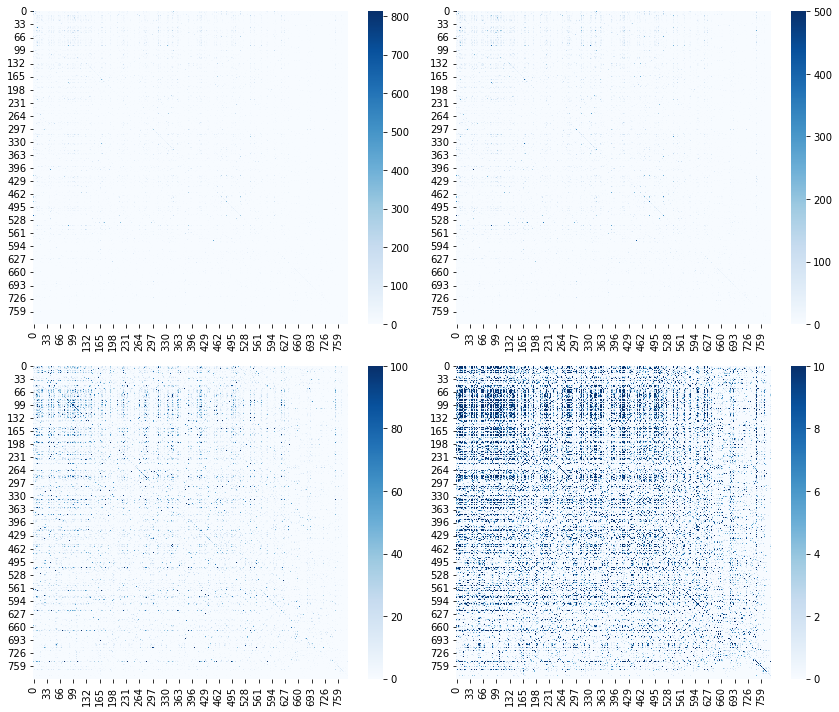

In [78]:
NY_df, NY_adj, NY_nodes_df, NY_nodes = adjacency(NY_df)

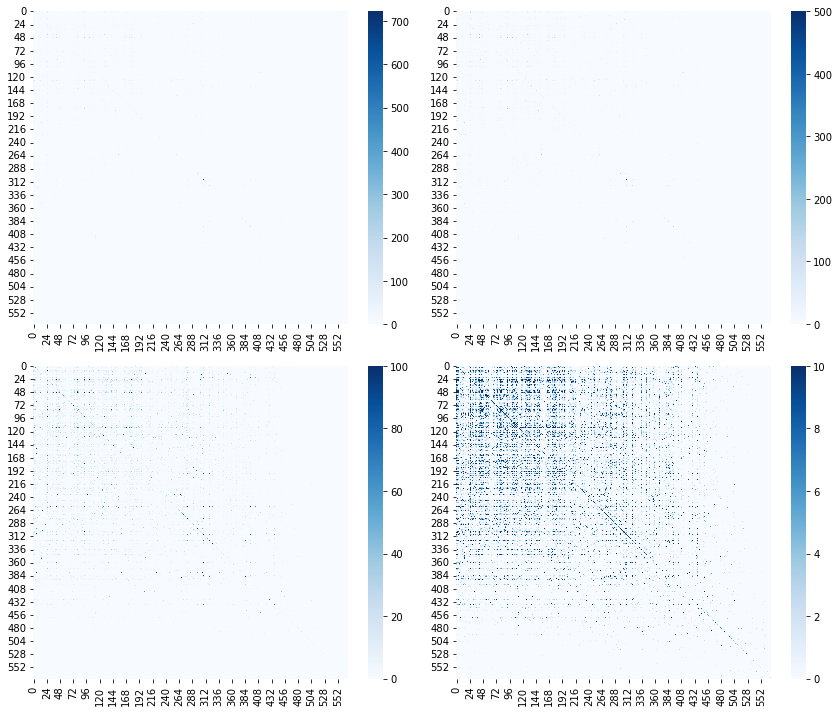

In [79]:
CHI_df, CHI_adj, CHI_nodes_df, CHI_nodes = adjacency(CHI_df)

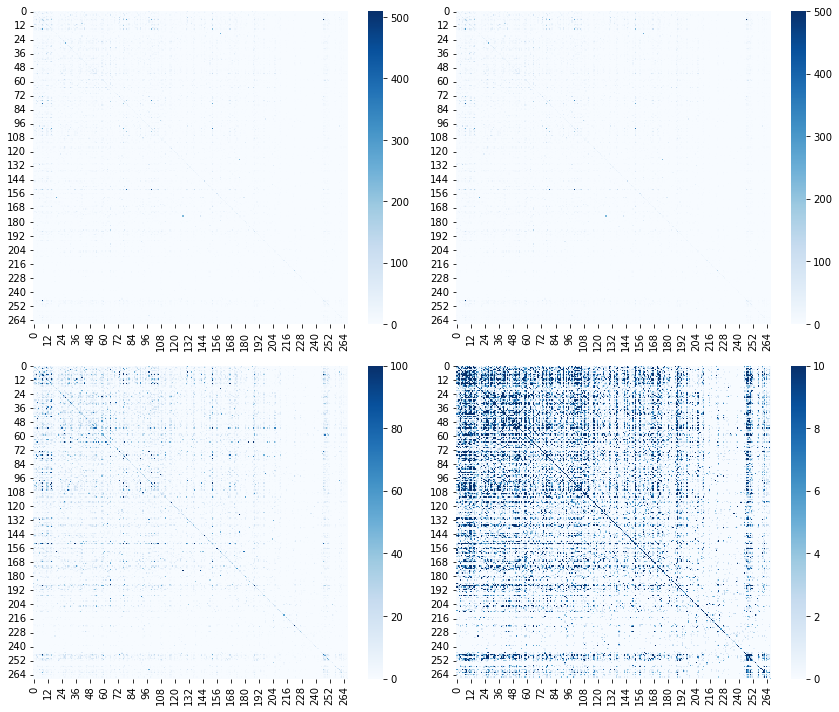

In [80]:
BOS_df, BOS_adj, BOS_nodes_df, BOS_nodes = adjacency(BOS_df)